In [1]:
from google.colab import drive
import os


drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import os
from sklearn.preprocessing import MinMaxScaler

# ==========================================
# 1. 하이퍼파라미터 및 설정
# ==========================================
file_path = "/content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx" # 파일 경로 확인 필요
experiments = ['l29', 'l31', 'l33']

BATCH_SIZE = 32
SEQ_LEN = 100         # 윈도우 길이 (이보다 짧으면 제외됨)
NUM_EPOCHS = 50
LATENT_DIM = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")
print(f"Experiments: {experiments}")

Device: cpu
Experiments: ['l29', 'l31', 'l33']


In [3]:
# ==========================================
# 2. 전처리 함수 (패딩 없이 짧은 데이터 제외)
# ==========================================
def preprocess_wafer_skip_short(wafer_data, seq_len):
    """
    길이가 seq_len보다 짧으면 빈 배열을 반환하여 제외시킴.
    길이가 충분하면 슬라이딩 윈도우 적용.
    """
    data_len = len(wafer_data)

    # 길이가 짧으면 제외 (Empty Array 반환)
    if data_len < seq_len:
        return np.array([])

    # 길이가 충분하면 슬라이딩 윈도우 생성
    sequences = []
    for i in range(data_len - seq_len + 1):
        sequences.append(wafer_data[i:i + seq_len])

    return np.array(sequences)

# ==========================================
# 3. 시각화 함수
# ==========================================
def plot_anomaly_scores(train_scores, test_scores, threshold, exp_id):
    all_scores = np.concatenate([train_scores, test_scores])
    x_train = np.arange(len(train_scores))
    x_test = np.arange(len(train_scores), len(all_scores))

    plt.figure(figsize=(12, 6))
    plt.scatter(x_train, train_scores, s=15, label='Normal (Train)', color='blue', alpha=0.5)
    plt.scatter(x_test, test_scores, s=15, label='Fault (Test)', color='red', alpha=0.7)

    if threshold is not None:
        plt.axhline(y=threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.4f})')

    plt.title(f'Anomaly Scores - {exp_id}', fontsize=16)
    plt.xlabel('Sample Index')
    plt.ylabel('Anomaly Score')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. 모델 정의 (USAD) & 학습 함수
# ==========================================
class USAD(nn.Module):
    def __init__(self, w_size, z_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(w_size, w_size // 2), nn.ReLU(),
            nn.Linear(w_size // 2, w_size // 4), nn.ReLU(),
            nn.Linear(w_size // 4, z_size), nn.ReLU()
        )
        self.decoder1 = nn.Sequential(
            nn.Linear(z_size, w_size // 4), nn.ReLU(),
            nn.Linear(w_size // 4, w_size // 2), nn.ReLU(),
            nn.Linear(w_size // 2, w_size), nn.Sigmoid()
        )
        self.decoder2 = nn.Sequential(
            nn.Linear(z_size, w_size // 4), nn.ReLU(),
            nn.Linear(w_size // 4, w_size // 2), nn.ReLU(),
            nn.Linear(w_size // 2, w_size), nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        return w1, w2, w3

def train_usad(model, train_loader, num_epochs, device):
    model = model.to(device)
    optimizer1 = optim.Adam(list(model.encoder.parameters()) + list(model.decoder1.parameters()), lr=1e-3)
    optimizer2 = optim.Adam(list(model.encoder.parameters()) + list(model.decoder2.parameters()), lr=1e-3)
    mse = nn.MSELoss()

    print("🔥 Training Start...")
    for epoch in range(num_epochs):
        model.train()
        n = epoch + 1
        for batch in train_loader:
            x = batch[0].to(device)
            x_flat = x.view(x.size(0), -1)

            optimizer1.zero_grad()
            w1, w2, w3 = model(x)
            loss1 = (1 / n) * mse(w1, x_flat) + (1 - 1 / n) * mse(w3, x_flat)
            loss1.backward()
            optimizer1.step()

            optimizer2.zero_grad()
            w1, w2, w3 = model(x)
            loss2 = (1 / n) * mse(w2, x_flat) - (1 - 1 / n) * mse(w3, x_flat)
            loss2.backward()
            optimizer2.step()
    return model

def evaluate_usad(model, data_loader, alpha=0.5, beta=0.5, device=device):
    model.eval()
    scores = []
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
            x_flat = x.view(x.size(0), -1)
            w1, w2, w3 = model(x)
            diff1 = torch.mean((x_flat - w1)**2, dim=1)
            diff2 = torch.mean((x_flat - w3)**2, dim=1)
            score = alpha * diff1 + beta * diff2
            scores.extend(score.cpu().numpy())
    return scores


🚀 Experiment [l29] 진행 중 (패딩 없음)
✅ [l29] Data Split Info:
   👉 Train (Normal): (123, 100, 20)
   👉 Test  (Fault) : (29, 100, 20)
------------------------------------------------------------
🔥 Training Start...
✅ [l29] 모델 학습 완료
📊 [l29] 최종 결과 | Normal: 123 | Fault: 29 | AUC: 0.7791


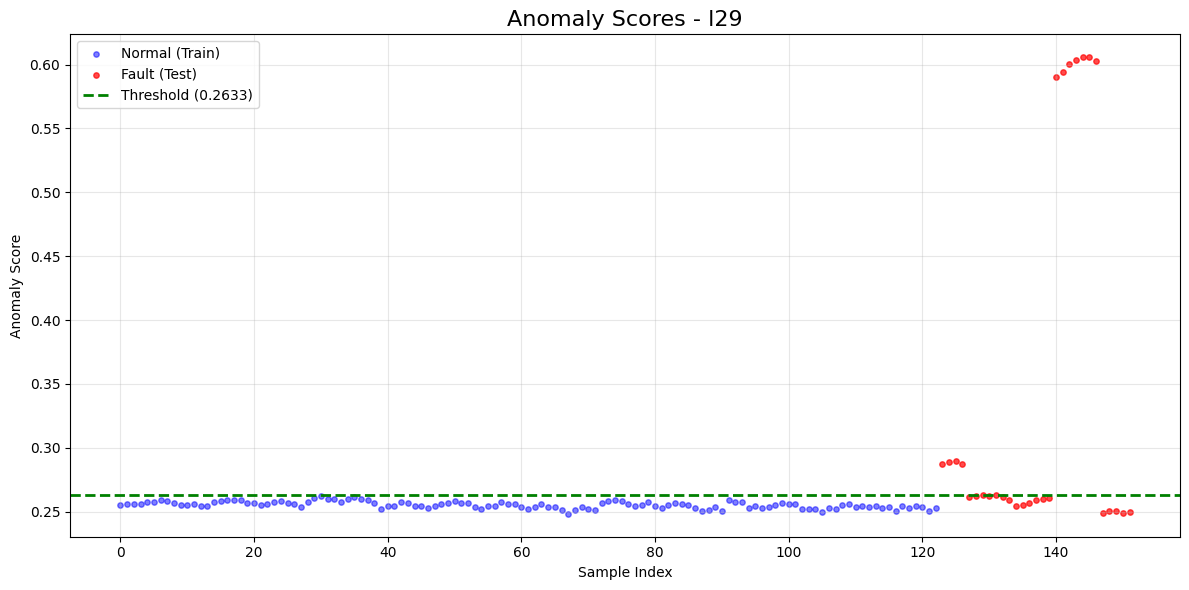

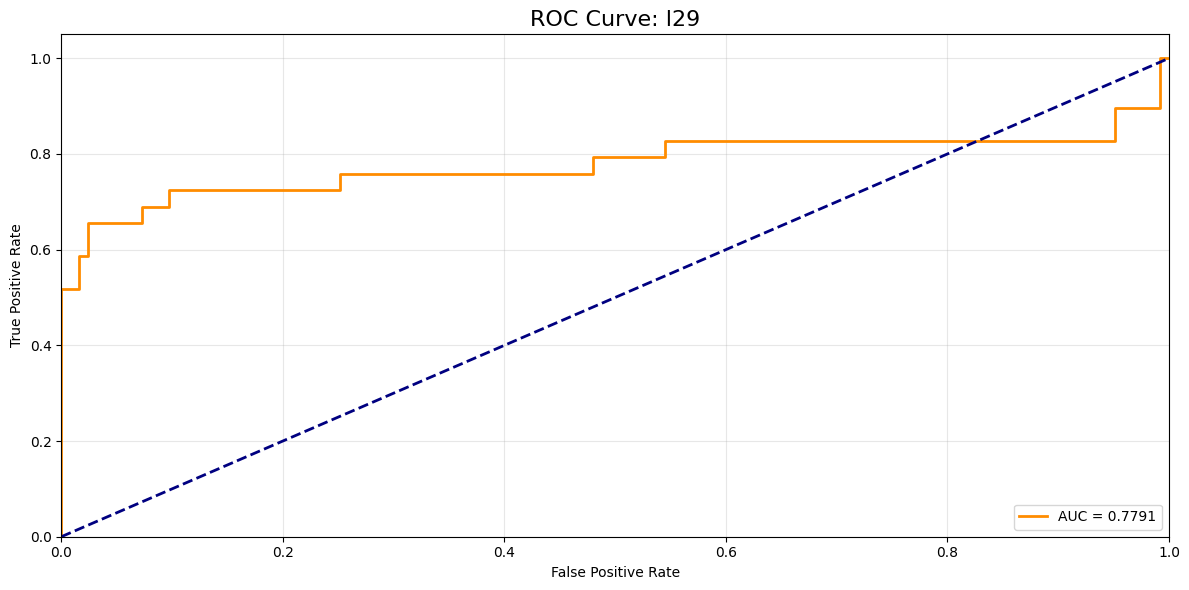


🚀 Experiment [l31] 진행 중 (패딩 없음)
✅ [l31] Data Split Info:
   👉 Train (Normal): (77, 100, 20)
   👉 Test  (Fault) : (2, 100, 20)
------------------------------------------------------------
🔥 Training Start...
✅ [l31] 모델 학습 완료
📊 [l31] 최종 결과 | Normal: 77 | Fault: 2 | AUC: 0.9545


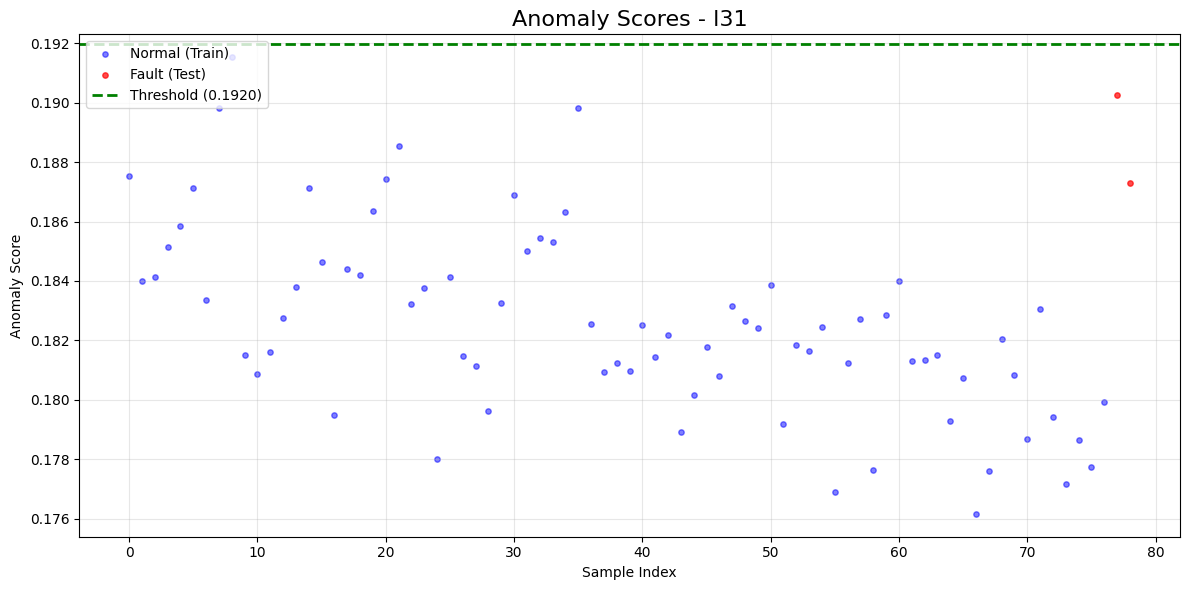

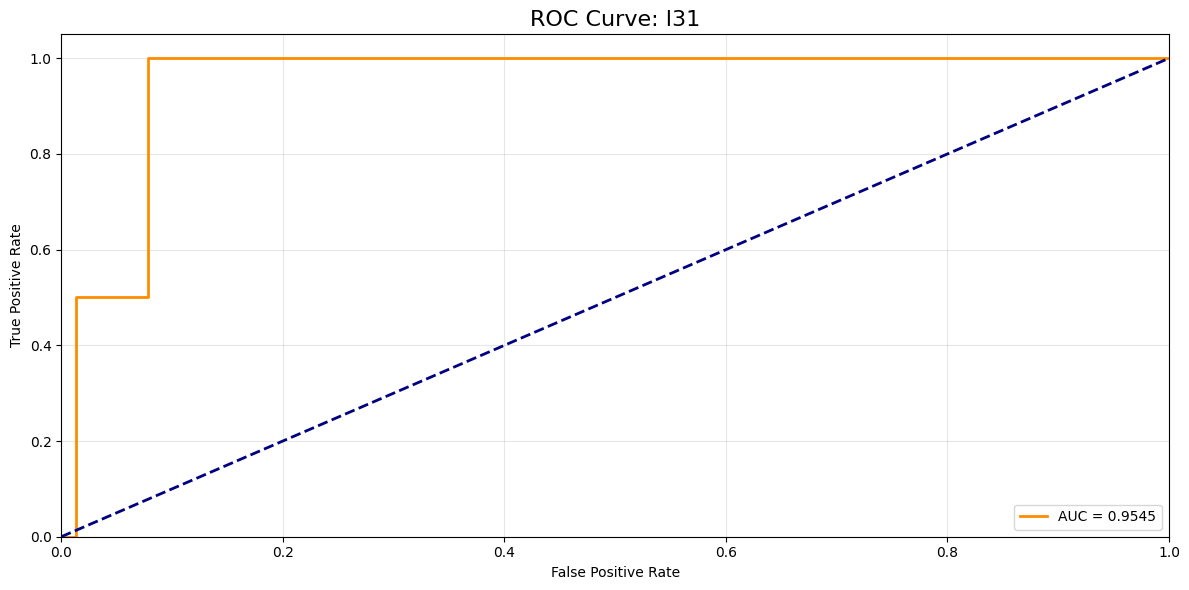


🚀 Experiment [l33] 진행 중 (패딩 없음)
✅ [l33] Data Split Info:
   👉 Train (Normal): (23, 100, 20)
   👉 Test  (Fault) : (16, 100, 20)
------------------------------------------------------------
🔥 Training Start...
✅ [l33] 모델 학습 완료
📊 [l33] 최종 결과 | Normal: 23 | Fault: 16 | AUC: 0.2120


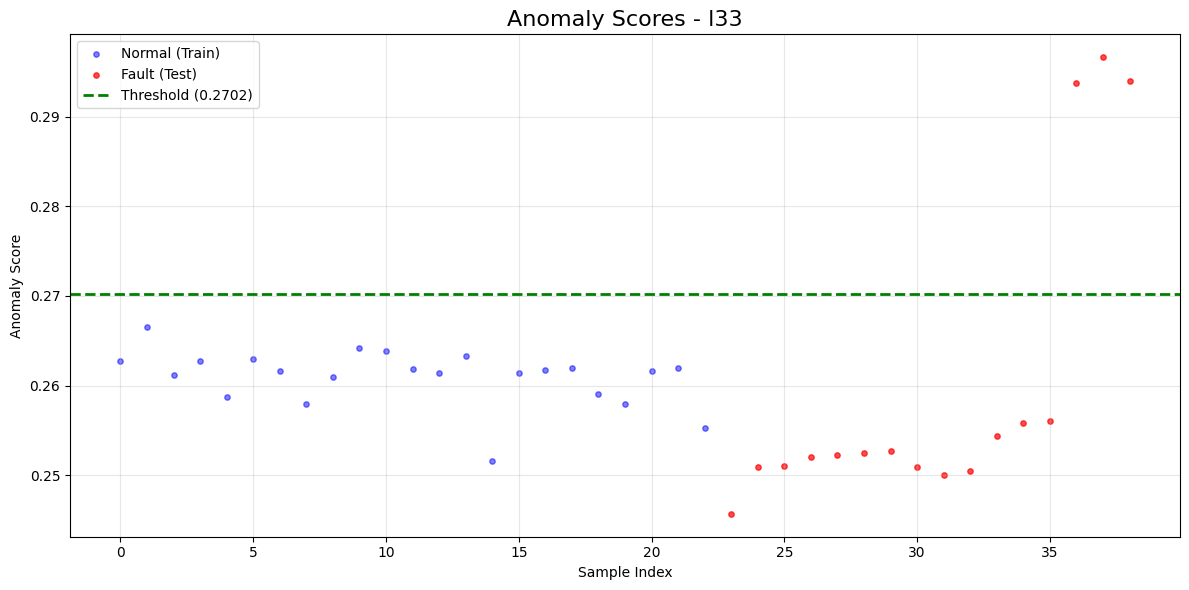

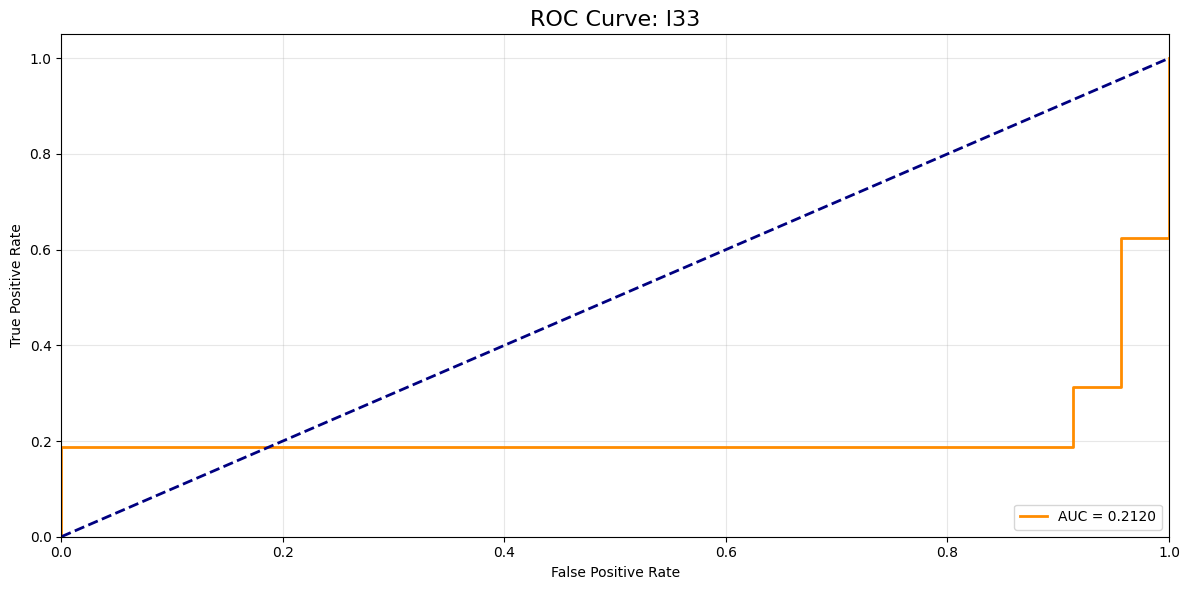


🏆 전체 실험 요약 (AUC Score)
Experiment l29: 0.7791
Experiment l31: 0.9545
Experiment l33: 0.2120


In [5]:
# ==========================================
# 5. 메인 실행 (통합 루프)
# ==========================================
if os.path.exists(file_path):
    if file_path.endswith('.xlsx'): df = pd.read_excel(file_path)
    else: df = pd.read_csv(file_path)
else:
    df = pd.DataFrame()
    print("❌ 파일을 찾을 수 없습니다.")

final_results = {}

if not df.empty:
    cols_to_exclude = ['Wafer_ID', 'Time_Step', 'Time', 'Label', 'Fault_Type']
    sensor_cols = [c for c in df.columns if c not in cols_to_exclude]
    sensor_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

    for idx, exp_id in enumerate(experiments):
        print(f"\n" + "="*50)
        print(f"🚀 Experiment [{exp_id}] 진행 중 (패딩 없음)")
        print("="*50)

        # 데이터 필터링
        exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]
        if exp_df.empty: continue

        normal_ids = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()
        fault_ids = exp_df[exp_df['Label'] == 'Fault']['Wafer_ID'].unique()

        scaler = MinMaxScaler()
        train_wafers_df = exp_df[exp_df['Wafer_ID'].isin(normal_ids)]
        scaler.fit(train_wafers_df[sensor_cols])

        # Train Data 생성 (짧은 데이터 제외)
        X_train = []
        for wid in normal_ids:
            w_df = exp_df[exp_df['Wafer_ID'] == wid][sensor_cols]
            w_scaled = scaler.transform(w_df)
            # ★ 변경된 전처리 함수 사용
            wins = preprocess_wafer_skip_short(w_scaled, SEQ_LEN)
            if len(wins) > 0: X_train.append(wins)

        if len(X_train) == 0:
            print(f"⚠️ [{exp_id}] 유효한(길이>{SEQ_LEN}) 학습 데이터가 없습니다. 건너뜁니다.")
            continue
        X_train = np.concatenate(X_train)

        # Test Data 생성 (짧은 데이터 제외)
        X_test_fault = []
        for wid in fault_ids:
            w_df = exp_df[exp_df['Wafer_ID'] == wid][sensor_cols]
            w_scaled = scaler.transform(w_df)
            # ★ 변경된 전처리 함수 사용
            wins = preprocess_wafer_skip_short(w_scaled, SEQ_LEN)
            if len(wins) > 0: X_test_fault.append(wins)

        if len(X_test_fault) > 0:
            X_test_fault = np.concatenate(X_test_fault)
        else:
            X_test_fault = np.zeros((0, SEQ_LEN, len(sensor_cols)))
            print(f"⚠️ [{exp_id}] 경고: 불량 데이터가 모두 {SEQ_LEN}보다 짧아서 제외되었습니다.")

        print(f"✅ [{exp_id}] Data Split Info:")
        print(f"   👉 Train (Normal): {X_train.shape}")
        if len(X_test_fault) > 0:
            print(f"   👉 Test  (Fault) : {X_test_fault.shape}")
        else:
            print(f"   👉 Test  (Fault) : (0, {SEQ_LEN}, {len(sensor_cols)})  <-- 데이터 부족으로 없음")
        print("-" * 60)



        # 모델 학습 및 평가
        input_dim = X_train.shape[1] * X_train.shape[2]
        train_tensor = torch.FloatTensor(X_train)

        if len(X_test_fault) > 0:
            test_fault_tensor = torch.FloatTensor(X_test_fault)
        else:
            test_fault_tensor = torch.FloatTensor([])

        train_loader = DataLoader(TensorDataset(train_tensor), batch_size=BATCH_SIZE, shuffle=True)
        eval_train_loader = DataLoader(TensorDataset(train_tensor), batch_size=BATCH_SIZE, shuffle=False)

        if len(test_fault_tensor) > 0:
            eval_test_loader = DataLoader(TensorDataset(test_fault_tensor), batch_size=BATCH_SIZE, shuffle=False)

        # 학습
        model = USAD(w_size=input_dim, z_size=LATENT_DIM)
        model = train_usad(model, train_loader, num_epochs=NUM_EPOCHS, device=device)
        print(f"✅ [{exp_id}] 모델 학습 완료")

        # 추론
        train_scores = evaluate_usad(model, eval_train_loader, device=device)

        if len(test_fault_tensor) > 0:
            test_scores = evaluate_usad(model, eval_test_loader, device=device)

            # 결과 출력
            y_true = np.concatenate([np.zeros(len(train_scores)), np.ones(len(test_scores))])
            y_scores = np.concatenate([train_scores, test_scores])

            if len(np.unique(y_true)) > 1:
                auc = roc_auc_score(y_true, y_scores)
                final_results[exp_id] = auc
                print(f"📊 [{exp_id}] 최종 결과 | Normal: {len(train_scores)} | Fault: {len(test_scores)} | AUC: {auc:.4f}")

                # 그래프 그리기
                threshold = np.mean(train_scores) + 3 * np.std(train_scores)
                plot_anomaly_scores(train_scores, test_scores, threshold, exp_id)

                fpr, tpr, _ = roc_curve(y_true, y_scores)
                plt.figure(figsize=(12, 6))
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.4f}')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve: {exp_id}', fontsize=16)
                plt.legend(loc="lower right")
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
        else:
            print(f"⚠️ [{exp_id}] 테스트할 불량 데이터가 없어 평가를 건너뜁니다.")

print("\n" + "="*50)
print("🏆 전체 실험 요약 (AUC Score)")
print("="*50)
for exp_id, score in final_results.items():
    print(f"Experiment {exp_id}: {score:.4f}")